# HW 1 - Evolutionary Computing

### Team

Raquel Cossío Ramírez - A01568041

Marie-Amélie Aymon - A01831591



### Optimization Analysis

- Methods
  - Hill Climber
  - Gradient Descent with Wolfe
  - Newton's Method
- Problems
  - A: quadratic
  - B: six-hump camel
  - C: Rastrigin


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
np.random.seed(0)

**1. Classical optimization methods**

## Problem Setting

In [ ]:
# Staying within bounds

def project_to_bounds(x, bounds):
    """
    Ensures each value in x stays within its corresponding [lo, hi] interval.
    """
    lo = np.array([b[0] for b in bounds], dtype=float)
    hi = np.array([b[1] for b in bounds], dtype=float)
    return np.minimum(np.maximum(x, lo), hi)

def box_corners(bounds):
    """
    Generate all corners of a box defined by bounds using only NumPy.
    """
    bounds_array = np.array(bounds, dtype=float)
    lows = bounds_array[:, 0]
    highs = bounds_array[:, 1]
    n = len(bounds)
    # Generate all binary combinations (0: low, 1: high)
    combos = np.array(np.meshgrid(*[[0, 1]] * n)).T.reshape(-1, n)
    corners = lows + combos * (highs - lows)
    return corners

In [ ]:
# EVALUATION. Define a class to count how many times a function is called

class EvalCounter:
    """
    Wraps a function and counts how many times it is called.
    This is used to track the number of function, gradient, and Hessian evaluations.
    """
    def __init__(self, func):
        self.func = func
        self.count = 0
    def __call__(self, *args, **kwargs):
        self.count += 1
        return self.func(*args, **kwargs)
    def reset(self):
        self.count = 0

* Implement in Python a continuous hill climber method for single objective minimization problems.

## Hill Climber

In [ ]:
# Hill Climber

def continuous_hill_climber(objective_func, bounds, initial_state, max_iterations=1000, step_size=0.01):
    """
    Simple greedy hill climber for minimization.
    At each step, randomly tweaks one coordinate by +/- step_size and accepts if it improves the objective.
    Returns the final solution, its value, and the number of iterations performed.
    """
    # Start at initial_state or pick a random point inside the bounds
    if initial_state is None:
        current = np.array([np.random.uniform(lo, hi) for (lo, hi) in bounds], dtype=float)
    else:
        current = np.array(initial_state, dtype=float)
        current = project_to_bounds(current, bounds)

    current_value = objective_func(current)

    # Track the number of iterations (always max_iterations for this implementation)
    for i in range(max_iterations):
        neighbor = current.copy()
        idx = np.random.randint(len(bounds))
        direction = np.random.choice([-1.0, 1.0])
        neighbor[idx] += direction * step_size
        neighbor = project_to_bounds(neighbor, bounds)
        neighbor_value = objective_func(neighbor)
        if neighbor_value < current_value:
            current, current_value = neighbor, neighbor_value

    return current, current_value, max_iterations

* Implement in Python a gradient descent method including Wolfe conditions for step size control (use the algorithm of point C). You can also compute the exact step size by minimizing $f(x+td)$ for $t$ in $R^+$.

## Wolfe

In [ ]:
# Wolfe line search + Gradient Descent

def step_to_box(x, p, bounds):
    """
    Computes the largest step t >= 0 along direction p so that x + t*p stays inside the box bounds.
    """
    alphas = []
    for xi, pi, (lo, hi) in zip(x, p, bounds):
        if pi > 0:
            alphas.append((hi - xi) / pi)
        elif pi < 0:
            alphas.append((lo - xi) / pi)
        else:
            alphas.append(np.inf)
    return max(0.0, min(alphas))

def wolfe_line_search(f, grad_f, x, p, bounds,
                t_init=1.0, c1=1e-4, c2=0.9,
                t_min=1e-12, t_max=2.0, max_ls_iter=50):
    """
    Performs a line search to find a step size t that satisfies the Wolfe conditions.
    Ensures the step does not leave the box bounds.
    """
    t_wall = step_to_box(x, p, bounds)
    t = min(t_init, t_wall, t_max)
    fx = f(x)
    gx = grad_f(x)
    gTp = float(gx @ p)

    # If not a descent direction, switch to steepest descent
    if gTp >= 0:
        p = -gx
        t_wall = step_to_box(x, p, bounds)
        t = min(t_init, t_wall, t_max)
        gTp = float(gx @ p)

    ls_iter = 0
    while ls_iter < max_ls_iter:
        t = min(t, t_wall, t_max)
        if t < t_min:
            return 0.0

        x_new = x + t * p
        fx_new = f(x_new)

        # Armijo condition: sufficient decrease
        if fx_new > fx + c1 * t * gTp:
            t *= 0.5
            ls_iter += 1
            continue

        # Strong Wolfe curvature condition
        g_new = grad_f(x_new)
        if abs(float(g_new @ p)) > c2 * abs(gTp):
            t_candidate = min(t * 2.0, t_wall, t_max)
            t = t_candidate if t_candidate > t else t * 0.5
            ls_iter += 1
            continue

        # Both conditions satisfied
        break

    return t

def gradient_descent_wolfe(f, grad_f, x0, bounds, max_iter=20, tol=1e-6):
    """
    Gradient descent with Wolfe line search and box constraints.
    """
    x = np.array(x0, dtype=float)
    x = project_to_bounds(x, bounds)
    history = []

    for i in range(max_iter):
        g = grad_f(x)
        grad_norm = float(np.linalg.norm(g))
        fx = f(x)
        history.append({
            'iter': i,
            'x': x.copy(),
            'f': fx,
            'grad_norm': grad_norm
        })

        if grad_norm < tol:
            break

        p = -g
        t = wolfe_line_search(f, grad_f, x, p, bounds)
        if t == 0.0:
            break

        x = x + t * p
        x = project_to_bounds(x, bounds)

    return x, history


* Implement in Python a Newton method for optimization.

## Newton

In [ ]:
# Newton's Method

def newton_method(f, grad_f, hess_f, x0, max_iter=20, tol=1e-6, use_wolfe=False, bounds=None):
    """
    Newton's method for optimization.
    Optionally uses Wolfe line search and box constraints if use_wolfe=True.

    IMPORTANT: This implementation includes a fallback mechanism.
    If the Newton direction fails the Wolfe line search (t == 0), it switches to the steepest descent direction (-g)
    and tries the Wolfe line search again. If that also fails, the method stops.
    This makes Newton much more robust for non-convex or difficult problems (like Rastrigin).
    """
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    for i in range(max_iter):
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        H = hess_f(x)
        try:
            p = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            p = -g

        if use_wolfe and bounds is not None:
            t = wolfe_line_search(f, grad_f, x, p, bounds)
            if t == 0.0:  # fallback to steepest descent if Newton step fails
                # This fallback is important for robustness!
                p = -g
                t = wolfe_line_search(f, grad_f, x, p, bounds)
                if t == 0.0:
                    # If even steepest descent fails, stop
                    break
            x = project_to_bounds(x + t*p, bounds)
        else:
            x = x + p

        history.append(x.copy())
    return x, history


## Problem A

In [ ]:
# Problem A

def f_A(x):
    """
    Quadratic function for Problem A.
    """
    x1, x2 = x
    return -2*(x1**2) + 3*x1*x2 - 1.5*(x2**2) - 1.3

def grad_f_A(x):
    """
    Gradient of Problem A.
    """
    x1, x2 = x
    return np.array([
        -4*x1 + 3*x2,
        3*x1 - 3*x2
    ], dtype=float)

def hess_f_A(x):
    """
    Hessian of Problem A (constant).
    """
    _ = x
    return np.array([[-4.0, 3.0],
                    [ 3.0,-3.0]], dtype=float)

## Problem B

In [ ]:
# Problem B

def f_B(x):
    """
    Nonlinear function for Problem B.
    """
    x1, x2 = x
    return (4 - 2.1*x1**2 + (x1**4)/3)*x1**2 + x1*x2 + (-4 + 4*x2**2)*x2**2

def grad_f_B(x):
    """
    Gradient of Problem B.
    """
    x1, x2 = x
    df_dx1 = (8*x1 - 8.4*x1**3 + (4/3)*x1**5) + x2
    df_dx2 = x1 + (-8*x2 + 16*x2**3)
    return np.array([df_dx1, df_dx2], dtype=float)

def hess_f_B(x):
    """
    Hessian of Problem B.
    """
    x1, x2 = x
    d2f_dx1x1 = 8 - 25.2*x1**2 + (20/3)*x1**4
    d2f_dx2x2 = -8 + 48*x2**2
    d2f_dx1dx2 = 1.0
    return np.array([[d2f_dx1x1, d2f_dx1dx2],
                    [d2f_dx1dx2, d2f_dx2x2]], dtype=float)

## Problem C

In [ ]:
# Problem C (Rastrigin)

def f_C(x):
    """
    Rastrigin function for Problem C (many local minima).
    """
    x1, x2 = x
    A = 10.0
    return A*2 + (x1**2 - A*np.cos(2*np.pi*x1)) + (x2**2 - A*np.cos(2*np.pi*x2))

def grad_f_C(x):
    """
    Gradient of Rastrigin function.
    """
    x1, x2 = x
    A = 10.0
    return np.array([
        2*x1 + 2*np.pi*A*np.sin(2*np.pi*x1),
        2*x2 + 2*np.pi*A*np.sin(2*np.pi*x2)
    ], dtype=float)

def hess_f_C(x):
    """
    Hessian of Rastrigin function (diagonal).
    """
    x1, x2 = x
    A = 10.0
    return np.array([
        [2 + 4*(np.pi**2)*A*np.cos(2*np.pi*x1), 0.0],
        [0.0, 2 + 4*(np.pi**2)*A*np.cos(2*np.pi*x2)]
    ], dtype=float)

In [ ]:
# Printing function

def print_results_table(results):
    """
    Print a formatted table comparing optimization results, with colors and borders.
    """
    # ANSI color codes for background
    YELLOW_BG = '\033[43m'
    BLUE_BG = '\033[44m'
    VIOLET_BG = '\033[45m'
    RESET = '\033[0m'
    BOLD = '\033[1m'

    # Map problem to color
    color_map = {
        "A": YELLOW_BG,
        "B": BLUE_BG,
        "C": VIOLET_BG
    }

    # Table header with all required columns
    header = [
        "Problem", "Method", "x*", "f(x*)", "Iterations", "Grad Norm",
        "f evals", "g evals", "H evals", "2-norm error", "Objective error"
    ]
    col_widths = [8, 28, 26, 14, 12, 12, 10, 10, 10, 16, 16]
    fmt = "│ " + " │ ".join([f"{{:<{w}}}" for w in col_widths]) + " │"
    total_width = sum(col_widths) + 3 * len(col_widths) + 1
    print("┌" + "─" * (total_width - 2) + "┐")
    print(fmt.format(*(BOLD + h + RESET for h in header)))
    print("├" + "─" * (total_width - 2) + "┤")
    for row in results:
        color = color_map.get(row[0], "")
        x_str = np.array2string(row[2], precision=6, separator=',', suppress_small=True)
        line = fmt.format(
            row[0], row[1], x_str, f"{row[3]:.8f}", row[4], f"{row[5]:.3e}",
            row[6], row[7], row[8], f"{row[9]:.3e}", f"{row[10]:.3e}"
        )
        print(f"{color}{line}{RESET}")
    print("└" + "─" * (total_width - 2) + "┘")


**2. Test your implemented methods (propose the configuration parameters of each method, initial step size, neighborhood size, etc.) in the following three problems (do it for minimization):**

For each problem, we will:

- Use correct reference optimum for error calculation

- Run each algorithm, counting evaluations and computing both 2-norm and objective value error

### Configuration parameters for each method:
- Hill Climber: step_size=0.01 (A, B), 0.05 (C, best-of-20); max_iterations=1000 (A, B), 60000 (C, best-of-20)
- Gradient Descent: Wolfe line search, max_iter=20, tol=1e-6, initial step size handled by Wolfe
- Newton's Method: max_iter=20, tol=1e-6, Wolfe line search and box constraints enabled

# Testing

In [ ]:
results = []
pd.DataFrame(results, columns=["Problem", "Method", "x*", "f(x*)", "Iterations", "Grad Norm", "f evals", "g evals", "H evals", "2-norm error", "Objective error"])

,Problem,Method,x*,f(x*),Iterations,Grad Norm,f evals,g evals,H evals,2-norm error,Objective error


In [ ]:
# --- Problem A setup ---
x0_A = np.array([-4.0, 4.0], dtype=float)
bounds_A = [(-6, 6), (-6, 6)]

# Wrap functions with counters for Problem A
fA_counter = EvalCounter(f_A)
gA_counter = EvalCounter(grad_f_A)
hA_counter = EvalCounter(hess_f_A)

In [ ]:
# Find "true" minimum for error calculation: evaluate all corners (since quadratic is concave)
corners_A = box_corners(bounds_A)
corner_vals_A = [f_A(corner) for corner in corners_A]
min_corner_idx_A = np.argmin(corner_vals_A)
xA_star = corners_A[min_corner_idx_A]
fA_star = corner_vals_A[min_corner_idx_A]


In [ ]:
# Hill Climber (A)
fA_counter.reset()
x_hc, f_hc, iters_hc = continuous_hill_climber(fA_counter, bounds_A, x0_A)
error_2norm = np.linalg.norm(x_hc - xA_star)
error_obj = abs(f_hc - fA_star)
results.append([
    "A", "Hill Climber", x_hc, f_hc, iters_hc, np.linalg.norm(grad_f_A(x_hc)),
    fA_counter.count, "-", "-", error_2norm, error_obj
])
pd.DataFrame(results, columns=["Problem", "Method", "x*", "f(x*)", "Iterations", "Grad Norm", "f evals", "g evals", "H evals", "2-norm error", "Objective error"])

,Problem,Method,x*,f(x*),Iterations,Grad Norm,f evals,g evals,H evals,2-norm error,Objective error
0,A,Hill Climber,"[-6.0, 6.0]",-235.3,1000,55.317267,1001,-,-,0.0,0.0


In [ ]:
# Gradient Descent with Wolfe (A)
fA_counter.reset(); gA_counter.reset()
x_gd, hist_gd = gradient_descent_wolfe(fA_counter, gA_counter, x0_A, bounds_A, max_iter=20)
error_2norm = np.linalg.norm(x_gd - xA_star)
error_obj = abs(f_A(x_gd) - fA_star)
results.append([
    "A", "Gradient Descent (Wolfe)", x_gd, f_A(x_gd), len(hist_gd), np.linalg.norm(grad_f_A(x_gd)),
    fA_counter.count, gA_counter.count, "-", error_2norm, error_obj
])
pd.DataFrame(results, columns=["Problem", "Method", "x*", "f(x*)", "Iterations", "Grad Norm", "f evals", "g evals", "H evals", "2-norm error", "Objective error"])

,Problem,Method,x*,f(x*),Iterations,Grad Norm,f evals,g evals,H evals,2-norm error,Objective error
0,A,Hill Climber,"[-6.0, 6.0]",-235.300000,1000,55.317267,1001,-,-,0.000000,0.000000
1,A,Gradient Descent (Wolfe),"[-6.0, 5.714285714285714]",-225.136735,2,54.108734,54,54,-,0.285714,10.163265


In [ ]:
# Newton Method (A) -- now constrained with Wolfe and bounds for fairness
fA_counter.reset(); gA_counter.reset(); hA_counter.reset()
x_nt, hist_nt = newton_method(fA_counter, gA_counter, hA_counter, x0_A, max_iter=20, use_wolfe=True, bounds=bounds_A)
error_2norm = np.linalg.norm(x_nt - xA_star)  # <-- FIXED: was error_2
error_obj = abs(f_A(x_nt) - fA_star)
results.append([
    "A", "Newton (constrained)", x_nt, f_A(x_nt), len(hist_nt), np.linalg.norm(grad_f_A(x_nt)),
    fA_counter.count, gA_counter.count, hA_counter.count, error_2norm, error_obj
])

,Problem,Method,x*,f(x*),Iterations,Grad Norm,f evals,g evals,H evals,2-norm error,Objective error
0,A,Hill Climber,"[-6.0, 6.0]",-235.300000,1000,5.531727e+01,1001,-,-,0.000000,0.000000
1,A,Gradient Descent (Wolfe),"[-6.0, 5.714285714285714]",-225.136735,2,5.410873e+01,54,54,-,0.285714,10.163265
2,A,Newton (constrained),"[1.6653345369377348e-16, 2.220446049250313e-16]",-1.300000,10,1.665335e-16,459,469,9,8.485281,234.000000


In [ ]:
# --- Problem B setup ---
x0_B = np.array([0.5, 1.0])
bounds_B = [(-3, 3), (-2, 2)]

# Wrap functions with counters for Problem B
fB_counter = EvalCounter(f_B)
gB_counter = EvalCounter(grad_f_B)
hB_counter = EvalCounter(hess_f_B)

# Find "true" minimum for error calculation: multi-start GD-Wolfe, keep best
best_xB, best_fB = None, np.inf
for _ in range(20):
    x0_rand = np.array([np.random.uniform(lo, hi) for (lo, hi) in bounds_B])
    x_gd, hist_gd = gradient_descent_wolfe(f_B, grad_f_B, x0_rand, bounds_B, max_iter=20)
    fval = f_B(x_gd)
    if fval < best_fB:
        best_xB, best_fB = x_gd, fval
xB_star, fB_star = best_xB, best_fB

In [ ]:
# Hill Climber (B)
fB_counter.reset()
x_hc, f_hc, iters_hc = continuous_hill_climber(fB_counter, bounds_B, x0_B)
error_2norm = np.linalg.norm(x_hc - xB_star)
error_obj = abs(f_hc - fB_star)
results.append([
    "B", "Hill Climber", x_hc, f_hc, iters_hc, np.linalg.norm(grad_f_B(x_hc)),
    fB_counter.count, "-", "-", error_2norm, error_obj
])

,Problem,Method,x*,f(x*),Iterations,Grad Norm,f evals,g evals,H evals,2-norm error,Objective error
0,A,Hill Climber,"[-6.0, 6.0]",-235.300000,1000,5.531727e+01,1001,-,-,0.000000,0.000000
1,A,Gradient Descent (Wolfe),"[-6.0, 5.714285714285714]",-225.136735,2,5.410873e+01,54,54,-,0.285714,10.163265
2,A,Newton (constrained),"[1.6653345369377348e-16, 2.220446049250313e-16]",-1.300000,10,1.665335e-16,459,469,9,8.485281,234.000000
3,B,Hill Climber,"[-0.0900000000000003, 0.7099999999999997]",-1.031570,1000,4.359738e-02,1001,-,-,1.433979,0.000058


In [ ]:
# Gradient Descent with Wolfe (B)
fB_counter.reset(); gB_counter.reset()
x_gd, hist_gd = gradient_descent_wolfe(fB_counter, gB_counter, x0_B, bounds_B, max_iter=20)
error_2norm = np.linalg.norm(x_gd - xB_star)
error_obj = abs(f_B(x_gd) - fB_star)
results.append([
    "B", "Gradient Descent (Wolfe)", x_gd, f_B(x_gd), len(hist_gd), np.linalg.norm(grad_f_B(x_gd)),
    fB_counter.count, gB_counter.count, "-", error_2norm, error_obj
])

,Problem,Method,x*,f(x*),Iterations,Grad Norm,f evals,g evals,H evals,2-norm error,Objective error
0,A,Hill Climber,"[-6.0, 6.0]",-235.300000,1000,5.531727e+01,1001,-,-,0.000000,0.000000e+00
1,A,Gradient Descent (Wolfe),"[-6.0, 5.714285714285714]",-225.136735,2,5.410873e+01,54,54,-,0.285714,1.016327e+01
2,A,Newton (constrained),"[1.6653345369377348e-16, 2.220446049250313e-16]",-1.300000,10,1.665335e-16,459,469,9,8.485281,2.340000e+02
3,B,Hill Climber,"[-0.0900000000000003, 0.7099999999999997]",-1.031570,1000,4.359738e-02,1001,-,-,1.433979,5.808964e-05
4,B,Gradient Descent (Wolfe),"[-0.08984253203589299, 0.7126564239142877]",-1.031628,14,2.153782e-07,172,86,-,1.436594,7.889245e-13


In [ ]:
# Newton Method (B)
fB_counter.reset(); gB_counter.reset(); hB_counter.reset()
x_nt, hist_nt = newton_method(fB_counter, gB_counter, hB_counter, x0_B, max_iter=20, use_wolfe=True, bounds=bounds_B)
error_2norm = np.linalg.norm(x_nt - xB_star)
error_obj = abs(f_B(x_nt) - fB_star)
results.append([
    "B", "Newton", x_nt, f_B(x_nt), len(hist_nt), np.linalg.norm(grad_f_B(x_nt)),
    fB_counter.count, gB_counter.count, hB_counter.count, error_2norm, error_obj
])

,Problem,Method,x*,f(x*),Iterations,Grad Norm,f evals,g evals,H evals,2-norm error,Objective error
0,A,Hill Climber,"[-6.0, 6.0]",-235.300000,1000,5.531727e+01,1001,-,-,0.000000,0.000000e+00
1,A,Gradient Descent (Wolfe),"[-6.0, 5.714285714285714]",-225.136735,2,5.410873e+01,54,54,-,0.285714,1.016327e+01
2,A,Newton (constrained),"[1.6653345369377348e-16, 2.220446049250313e-16]",-1.300000,10,1.665335e-16,459,469,9,8.485281,2.340000e+02
3,B,Hill Climber,"[-0.0900000000000003, 0.7099999999999997]",-1.031570,1000,4.359738e-02,1001,-,-,1.433979,5.808964e-05
4,B,Gradient Descent (Wolfe),"[-0.08984253203589299, 0.7126564239142877]",-1.031628,14,2.153782e-07,172,86,-,1.436594,7.889245e-13
5,B,Newton,"[-1.02580037083235, 0.7653246389330802]",0.516512,9,1.140937e-01,441,189,9,1.851779,1.548140e+00


In [ ]:
# --- Problem C setup ---
bounds_C = [(-2.0, 2.0), (-2.0, 2.0)]
x0_C = np.array([-2.0, 2.0], dtype=float)

# Wrap functions with counters for Problem C
fC_counter = EvalCounter(f_C)
gC_counter = EvalCounter(grad_f_C)
hC_counter = EvalCounter(hess_f_C)

# Reference optimum for C is at (0,0) with f=0
xC_star = np.array([0.0, 0.0])
fC_star = 0.0


In [ ]:
# Hill Climber (C)
fC_counter.reset()
x_hc, f_hc, iters_hc = continuous_hill_climber(fC_counter, bounds_C, x0_C)
error_2norm = np.linalg.norm(x_hc - xC_star)
error_obj = abs(f_hc - fC_star)
results.append([
    "C", "Hill Climber", x_hc, f_hc, iters_hc, np.linalg.norm(grad_f_C(x_hc)),
    fC_counter.count, "-", "-", error_2norm, error_obj
])

,Problem,Method,x*,f(x*),Iterations,Grad Norm,f evals,g evals,H evals,2-norm error,Objective error
0,A,Hill Climber,"[-6.0, 6.0]",-235.300000,1000,5.531727e+01,1001,-,-,0.000000,0.000000e+00
1,A,Gradient Descent (Wolfe),"[-6.0, 5.714285714285714]",-225.136735,2,5.410873e+01,54,54,-,0.285714,1.016327e+01
2,A,Newton (constrained),"[1.6653345369377348e-16, 2.220446049250313e-16]",-1.300000,10,1.665335e-16,459,469,9,8.485281,2.340000e+02
3,B,Hill Climber,"[-0.0900000000000003, 0.7099999999999997]",-1.031570,1000,4.359738e-02,1001,-,-,1.433979,5.808964e-05
4,B,Gradient Descent (Wolfe),"[-0.08984253203589299, 0.7126564239142877]",-1.031628,14,2.153782e-07,172,86,-,1.436594,7.889245e-13
5,B,Newton,"[-1.02580037083235, 0.7653246389330802]",0.516512,9,1.140937e-01,441,189,9,1.851779,1.548140e+00
6,C,Hill Climber,"[-1.99, 1.99]",7.959665,1000,4.915142e-02,1001,-,-,2.814285,7.959665e+00


In [ ]:
# Hill Climber (C, best of 20 restarts)
best_x, best_f, best_iters = None, np.inf, 0
for _ in range(20):
    x_rand = np.array([np.random.uniform(lo, hi) for (lo, hi) in bounds_C])
    x_hc, f_hc, iters_hc = continuous_hill_climber(fC_counter, bounds_C, x_rand, max_iterations=60000, step_size=0.05)
    if f_hc < best_f:
        best_x, best_f, best_iters = x_hc, f_hc, iters_hc
error_2norm = np.linalg.norm(best_x - xC_star)
error_obj = abs(best_f - fC_star)
results.append([
    "C", "Hill Climber (best of 20)", best_x, best_f, best_iters, np.linalg.norm(grad_f_C(best_x)),
    fC_counter.count, "-", "-", error_2norm, error_obj
])
pd.DataFrame(results, columns=["Problem", "Method", "x*", "f(x*)", "Iterations", "Grad Norm", "f evals", "g evals", "H evals", "2-norm error", "Objective error"])

,Problem,Method,x*,f(x*),Iterations,Grad Norm,f evals,g evals,H evals,2-norm error,Objective error
0,A,Hill Climber,"[-6.0, 6.0]",-235.300000,1000,5.531727e+01,1001,-,-,0.000000,0.000000e+00
1,A,Gradient Descent (Wolfe),"[-6.0, 5.714285714285714]",-225.136735,2,5.410873e+01,54,54,-,0.285714,1.016327e+01
2,A,Newton (constrained),"[1.6653345369377348e-16, 2.220446049250313e-16]",-1.300000,10,1.665335e-16,459,469,9,8.485281,2.340000e+02
3,B,Hill Climber,"[-0.0900000000000003, 0.7099999999999997]",-1.031570,1000,4.359738e-02,1001,-,-,1.433979,5.808964e-05
4,B,Gradient Descent (Wolfe),"[-0.08984253203589299, 0.7126564239142877]",-1.031628,14,2.153782e-07,172,86,-,1.436594,7.889245e-13
5,B,Newton,"[-1.02580037083235, 0.7653246389330802]",0.516512,9,1.140937e-01,441,189,9,1.851779,1.548140e+00
6,C,Hill Climber,"[-1.99, 1.99]",7.959665,1000,4.915142e-02,1001,-,-,2.814285,7.959665e+00
7,C,Hill Climber (best of 20),"[0.0010879690957508875, 0.01018151711425315]",0.020794,60000,4.060138e+00,1201021,-,-,0.010239,2.079383e-02


In [ ]:
# Gradient Descent with Wolfe (C)
fC_counter.reset(); gC_counter.reset()
x_gd, hist_gd = gradient_descent_wolfe(fC_counter, gC_counter, x0_C, bounds_C, max_iter=20)
error_2norm = np.linalg.norm(x_gd - xC_star)
error_obj = abs(f_C(x_gd) - fC_star)
results.append([
    "C", "Gradient Descent (Wolfe)", x_gd, f_C(x_gd), len(hist_gd), np.linalg.norm(grad_f_C(x_gd)),
    fC_counter.count, gC_counter.count, "-", error_2norm, error_obj
])

In [ ]:
# Newton Method (C)
fC_counter.reset(); gC_counter.reset(); hC_counter.reset()
x_nt, hist_nt = newton_method(fC_counter, gC_counter, hC_counter, x0_C, max_iter=20, use_wolfe=True, bounds=bounds_C)
error_2norm = np.linalg.norm(x_nt - xC_star)
error_obj = abs(f_C(x_nt) - fC_star)
results.append([
    "C", "Newton", x_nt, f_C(x_nt), len(hist_nt), np.linalg.norm(grad_f_C(x_nt)),
    fC_counter.count, gC_counter.count, hC_counter.count, error_2norm, error_obj
])

**3. Make a comparison table of the number of iterations to find a nearly optimal solution. To achieve this, investigate or compute the minimum of each function. Count every function iteration, every computed gradient, and Hessian. Compute the error of the optimal value against the obtained value by each algorithm using the two-norm. If nothing happens after 20 iterations of the derivative-based methods, stop. You can use the gradient norm to check this. In the case of the hill climber, you will need more iterations.**

In [ ]:
# Plotting function
def plot_problem_contours(f, bounds, results, prob_label, filename, ref_opt=None, dpi=200, margin_ratio=0.08):
    plt.figure(figsize=(8, 6))
    lo1, hi1 = bounds[0]
    lo2, hi2 = bounds[1]
    m1 = (hi1 - lo1) * margin_ratio
    m2 = (hi2 - lo2) * margin_ratio

    # grid slightly larger than the box
    x1_range = np.linspace(lo1 - m1, hi1 + m1, 500)
    x2_range = np.linspace(lo2 - m2, hi2 + m2, 500)
    X1, X2 = np.meshgrid(x1_range, x2_range)

    # safe evaluation of Z
    Z = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            Z[i, j] = f([X1[i, j], X2[i, j]])

    cs = plt.contour(X1, X2, Z, levels=50, cmap='viridis', alpha=0.5)
    plt.colorbar(cs, label='f(x1, x2) value')

    plt.xlim(lo1 - m1, hi1 + m1)
    plt.ylim(lo2 - m2, hi2 + m2)
    plt.grid(True)
    plt.title(f"Optimization Results for Problem {prob_label}")
    plt.xlabel("x1")
    plt.ylabel("x2")

    # Collect points for this problem
    pts = []
    for row in results:
        if row[0] != prob_label:
            continue
        label = None
        if "Hill Climber (best of 20)" in row[1]:
            label = "Hill Climber (best of 20)"
        elif "Hill Climber" in row[1]:
            label = "Hill Climber"
        elif "Gradient Descent" in row[1]:
            label = "Gradient Descent (Wolfe)"
        elif "Newton" in row[1]:
            label = "Newton"
        pts.append((label, np.array(row[2])))

    # Define marker/color for each method
    marker_map = {
        "Newton":      ('^', 'g'),
        "Gradient Descent (Wolfe)": ('s', 'b'),
        "Hill Climber": ('o', 'r'),
        "Hill Climber (best of 20)": ('o', 'm'),
    }

    # Annotation offsets (dx, dy) for each method to avoid overlap
    # These are chosen to spread out the labels
    offset_map = {
        "Newton":      (0.04, 0.04),
        "Gradient Descent (Wolfe)": (-0.04, -0.04),
        "Hill Climber": (0.04, -0.04),
        "Hill Climber (best of 20)": (-0.04, 0.04),
    }

    # Plot each method, annotate with offset
    plotted = set()
    for label, x_star in pts:
        if label is None or label in plotted:
            continue
        marker, color = marker_map[label]
        plt.scatter(x_star[0], x_star[1], s=120, c=color, marker=marker, edgecolors='k', linewidths=2, zorder=6, alpha=0.85, label=label)
        dx, dy = offset_map[label]
        # Check if any other point is very close, if so, increase offset
        for _, other in pts:
            if np.allclose(x_star, other) and not np.all(x_star == other):
                dx += 0.02
                dy += 0.02
        plt.text(x_star[0]+dx, x_star[1]+dy, label, fontsize=9, ha="center", va="center", color=color, weight='bold', zorder=7,
                  bbox=dict(boxstyle="round,pad=0.18", fc="white", ec=color, alpha=0.8, lw=1))
        plotted.add(label)

    # Plot reference optimum as black star if provided
    if ref_opt is not None:
        plt.scatter(ref_opt[0], ref_opt[1], s=200, c='k', marker='*', edgecolors='k', linewidths=2.2, zorder=8, label="Reference Optimum")
        plt.text(ref_opt[0], ref_opt[1]-0.05, "Optimum", fontsize=10, ha="center", va="top", color='k', weight='bold', zorder=9,
                  bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="k", alpha=0.8, lw=1))

    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(filename, dpi=dpi)
    plt.close()

In [ ]:
# --- Plot for Problem A ---
plot_problem_contours(f_A, bounds_A, results, "A", "problem_A.png", ref_opt=xA_star)
img_A = plt.imread("problem_A.png")

In [ ]:
# --- Plot for Problem B ---
plot_problem_contours(f_B, bounds_B, results, "B", "problem_B.png", ref_opt=xB_star)
img_B = plt.imread("problem_B.png")

In [ ]:
# --- Plot for Problem C ---
plot_problem_contours(f_C, bounds_C, results, "C", "problem_C.png", ref_opt=xC_star)
img_C = plt.imread("problem_C.png")


# Results

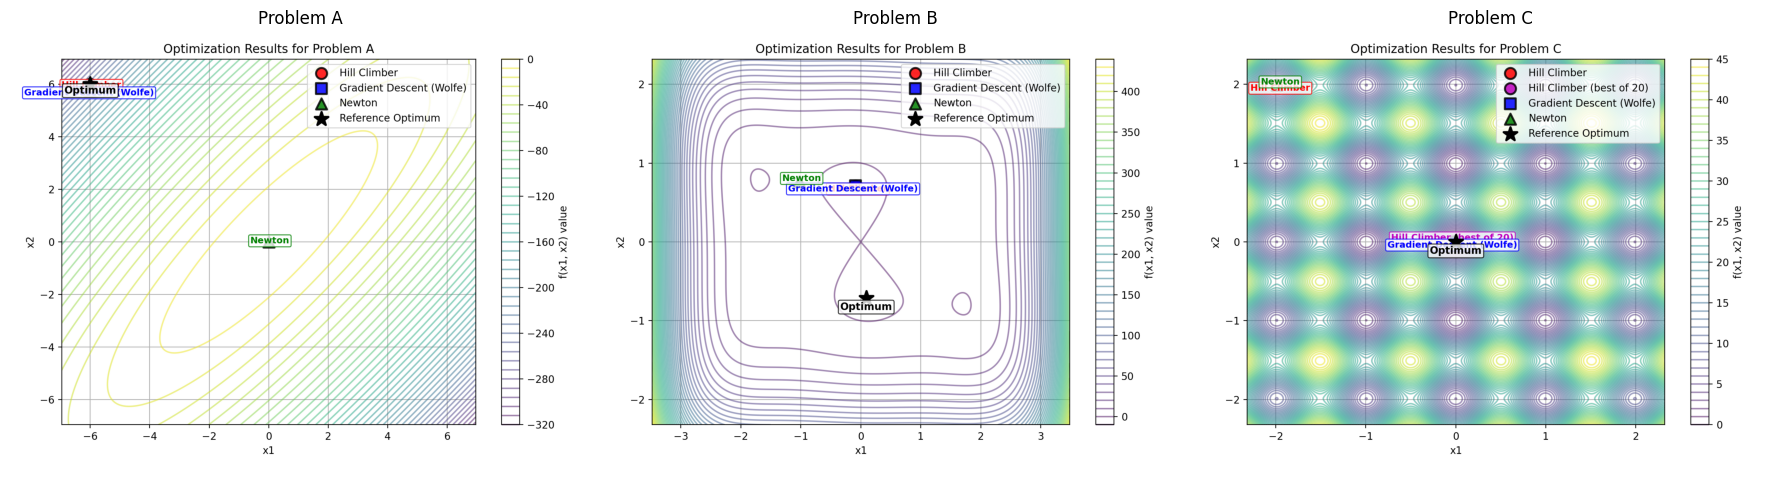

In [ ]:
# --- Show all three plots together ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(img_A)
axs[0].set_title("Problem A")
axs[0].axis('off')
axs[1].imshow(img_B)
axs[1].set_title("Problem B")
axs[1].axis('off')
axs[2].imshow(img_C)
axs[2].set_title("Problem C")
axs[2].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Print the comparison table
print("\n\n=== Optimization Results Comparison Table ===")
pd.DataFrame(results, columns=["Problem", "Method", "x*", "f(x*)", "Iterations", "Grad Norm", "f evals", "g evals", "H evals", "2-norm error", "Objective error"])



=== Optimization Results Comparison Table ===


,Problem,Method,x*,f(x*),Iterations,Grad Norm,f evals,g evals,H evals,2-norm error,Objective error
0,A,Hill Climber,"[-6.0, 6.0]",-235.300000,1000,5.531727e+01,1001,-,-,0.000000e+00,0.000000e+00
1,A,Gradient Descent (Wolfe),"[-6.0, 5.714285714285714]",-225.136735,2,5.410873e+01,54,54,-,2.857143e-01,1.016327e+01
2,A,Newton (constrained),"[1.6653345369377348e-16, 2.220446049250313e-16]",-1.300000,10,1.665335e-16,459,469,9,8.485281e+00,2.340000e+02
3,B,Hill Climber,"[-0.0900000000000003, 0.7099999999999997]",-1.031570,1000,4.359738e-02,1001,-,-,1.433979e+00,5.808964e-05
4,B,Gradient Descent (Wolfe),"[-0.08984253203589299, 0.7126564239142877]",-1.031628,14,2.153782e-07,172,86,-,1.436594e+00,7.889245e-13
5,B,Newton,"[-1.02580037083235, 0.7653246389330802]",0.516512,9,1.140937e-01,441,189,9,1.851779e+00,1.548140e+00
6,C,Hill Climber,"[-1.99, 1.99]",7.959665,1000,4.915142e-02,1001,-,-,2.814285e+00,7.959665e+00
7,C,Hill Climber (best of 20),"[0.0010879690957508875, 0.01018151711425315]",0.020794,60000,4.060138e+00,1201021,-,-,1.023948e-02,2.079383e-02
8,C,Gradient Descent (Wolfe),"[-1.532107773982716e-14, 1.532107773982716e-14]",0.000000,2,8.597232e-12,5,4,-,2.166728e-14,0.000000e+00
9,C,Newton,"[-1.989912233717502, 1.989912233717502]",7.959662,3,5.013386e-09,4,7,2,2.814161e+00,7.959662e+00


**4. Explain which method you select to solve each of the problems and explain why.**

- We chose hill Climber for problem A as it reached the minimum value in the function. Wolfe method was also a good result but it did not reached the minimum. On the countrary Newton Method did not reached an optimized value due to the inizialization at the top of the 'hill' that has zero slope.
- For problem B we chose Wolfe algorithm because we obtained less error in just 14 iterations
- For Problem C we chose Wolfe too because it converged in just 2 iterations with no error but either Hill Climber or Newton found a local minimum.

**5. Can evolutionary algorithms help to solve any of the previous problems? Why?**

Yes, evolutionary algorithms should find the optimal solution to this problems as they can be mathemathically formulated (observed result is equal to the function output). Also, evolutionary algorithms can optimize over the majority of the search space and can be less prone to getting stuck into a local minima as the iitial population is randomly generated.

The only issue with EA is that is more computationally intensive and it depends on the initial parameters such as population size, mutation rate and selection strategy